Counter({'neutral': 86, 'surprise': 82, 'happy': 75, 'sadness': 41, 'anger': 40, 'fear': 16})
Counter({'neutral': 36, 'surprise': 35, 'happy': 30, 'anger': 18, 'sadness': 17, 'fear': 7})
Accuracy: 0.6363636363636364
Confusion Matrix:
 [[ 4  0  0 12  2  0]
 [ 0  0  0  3  4  0]
 [ 0  0 26  4  0  0]
 [ 1  0  1 28  1  5]
 [ 1  0  0  8  7  1]
 [ 0  0  0  9  0 26]]
AUC Scores per Class: {'sadness': 0.7432306255835668, 'neutral': 0.6321391484942886, 'anger': 0.4057777777777778, 'surprise': 0.35264550264550265, 'happy': 0.2014749262536873, 'fear': 0.4642857142857143}
Macro-Averaged AUC: 0.4665922825067563


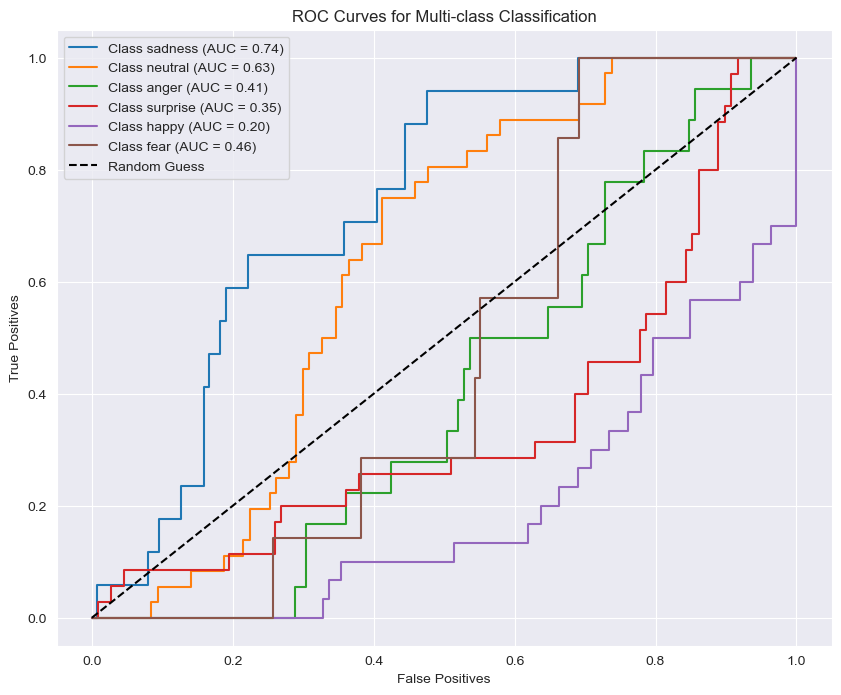

F1-Scores per class: [0.33333333 0.         0.9122807  0.56       0.4516129  0.7761194 ]
Macro-Averaged F1-Score: 0.5055577235497667
Weighted-Averaged F1-Score: 0.6179721644192161


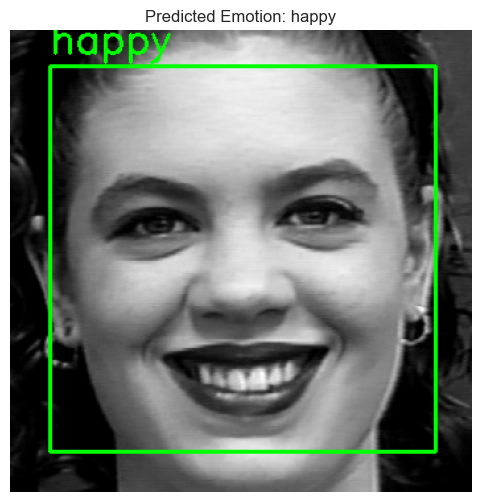

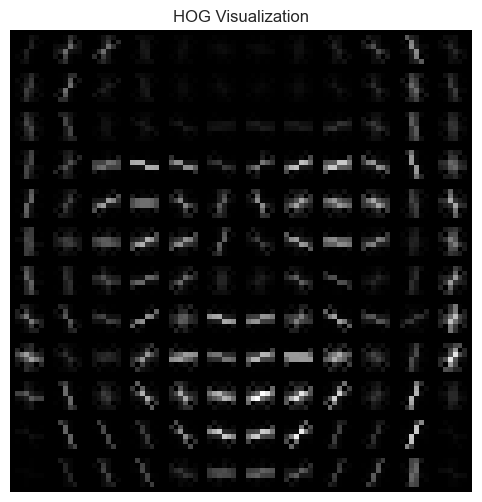

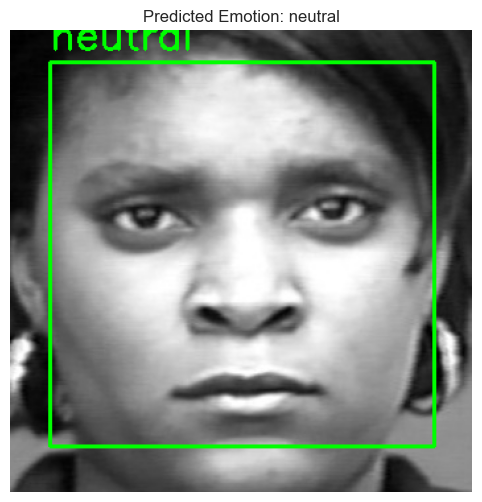

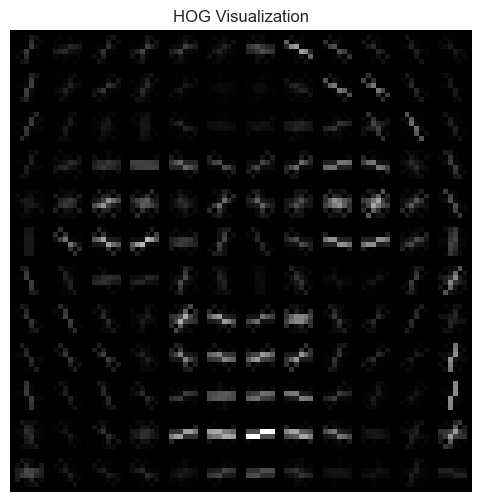

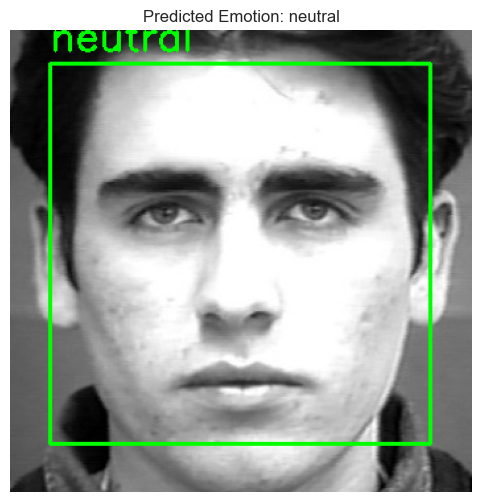

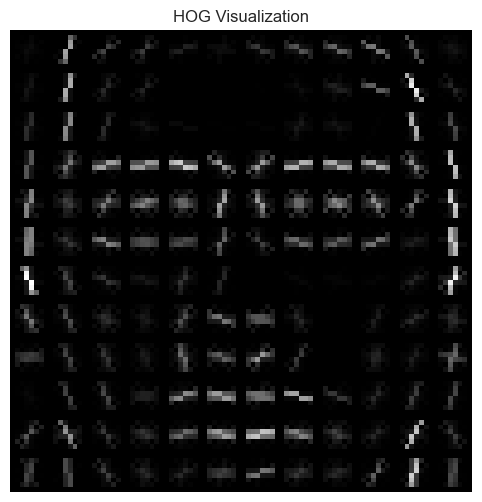

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_curve
from skimage.feature import hog
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import albumentations as A
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score, classification_report



face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

augmenter = A.Compose([
    A.HorizontalFlip(p=0.5),  # I have adjusted to try and get best perfomance. 
    A.Rotate(limit=10, p=0.5),  
    A.GaussianBlur(blur_limit=(1, 3), p=0.3),  
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),  
])

# create new images from existing images. 
def augment_images(class_folder, save_folder, augment_count=100):
    images = []
    for img_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)

    new_images = []
    for img in images:
        for _ in range(augment_count // len(images)):  # Augment to the target count
            augmented = augmenter(image=img)["image"]
            new_images.append(augmented)
    
    # Save the images generated here
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    for idx, aug_img in enumerate(new_images):
        save_path = os.path.join(save_folder, f"aug_{idx}.jpg") # use jpeg for consistency with CK.
        cv2.imwrite(save_path, aug_img)


class_folder_fear = "CK_dataset/train/fear"  
save_folder_fear = "CK_dataset/train/fear"  

class_folder_sad = "CK_dataset/train/sadness"  
save_folder_sad = "CK_dataset/train/sadness"

class_folder_anger = "CK_dataset/train/anger"  
save_folder_anger = "CK_dataset/train/anger" # add back to train folder so they're included in the training data.

# augment_images(class_folder_fear, save_folder_fear, augment_count=70)

# augment_images(class_folder_sad, save_folder_sad, augment_count=45)

# augment_images(class_folder_anger, save_folder_anger, augment_count=46)

# Function to read in and detect facial images. 
def load_detect_faces(path):
    images = []
    labels = []
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
                    for (x, y, w, h) in faces:
                        face_region = img[y:y + h, x:x + w]
                        images.append(face_region)
                        labels.append(label)
    return images, labels  # I moved the return outside the loop


def preprocess_images(images):
    preprocessed_images = []
    for image in images:
        img = cv2.equalizeHist(image)
        preprocessed_images.append(img)
    return preprocessed_images


def hog_feature_extraction(images):
    hog_features = []
    for image in images:
        image = cv2.resize(image, (96, 96))  # use 96 for more detail/pixels. 32 only produced 0.5 accuracy. 
        hog_feature = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')
        hog_features.append(hog_feature)
    return np.array(hog_features)


train_folder_path = "CK_dataset/train/"
test_folder_path = "CK_dataset/test/"
# Load and process the data
X_train, y_train = load_detect_faces(train_folder_path)
X_test, y_test = load_detect_faces(test_folder_path)

class_imbalance_train = Counter(y_train)
class_imbalance_test = Counter(y_test)

print(class_imbalance_train)
print(class_imbalance_test)

X_train = preprocess_images(X_train)  # pre-processing training data enhances accuracy. 

X_train_features = hog_feature_extraction(X_train)
X_test_features = hog_feature_extraction(X_test)

# try some custom weightings to see if I can get better performnce.
# class_weights = {'happy': 3, 'surprise': 3, 'anger': 2, 'neutral': 1, 'sadness': 1, 'fear': 2}
# svm = make_pipeline( StandardScaler(), SVC(kernel='rbf', C=7, gamma='scale', class_weight=class_weights, probability=True))

# Build and train the SVM model

svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=7, gamma='scale', probability=True, class_weight='balanced'))
svm.fit(X_train_features, y_train)

# Test the model
y_pred = svm.predict(X_test_features)
y_pred_proba = svm.predict_proba(X_test_features)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


def extract_face_hog(img):
    img = cv2.resize(img, (96, 96))
    hog_features, hog_image = hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                                  block_norm='L2-Hys', visualize=True)
    return hog_features, hog_image


def predict_emotion(img_path, model):
    # Read the image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image cannot be read.")

    # Convert to grayscale
    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(grey_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        raise ValueError("No faces detected.")

    for (x, y, w, h) in faces:
        # Extract face region
        face_region = grey_img[y:y + h, x:x + w]

        # Extract HOG features
        hog_features, hog_image = extract_face_hog(face_region)
        hog_features = hog_features.reshape(1, -1)

        # Predict emotion
        pred_emotion = model.predict(hog_features)[0]

        # Visualise the results
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box around face
        cv2.putText(img_rgb, pred_emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Show the image with predictions
        plt.figure(figsize=(10, 6))
        plt.imshow(img_rgb)
        plt.title(f"Predicted Emotion: {pred_emotion}")
        plt.axis("off")
        plt.show()

        # show the HOG visualisation
        plt.figure(figsize=(10, 6))
        plt.imshow(hog_image, cmap='gray')
        plt.title("HOG Visualization")
        plt.axis("off")
        plt.show()


# Binarize the labels for multi-class AUC
classes = list(set(y_train))  # List of unique classes
y_test_bin = label_binarize(y_test, classes=classes)

# Calculate AUC for each class (One-vs-Rest)
auc_scores = roc_auc_score(y_test_bin, y_pred_proba, average=None)

# Calculate average AUC
average_auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro')

print("AUC Scores per Class:", dict(zip(classes, auc_scores)))
print("Macro-Averaged AUC:", average_auc)


plt.figure(figsize=(10, 8))

for idx, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, idx], y_pred_proba[:, idx])
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {auc_scores[idx]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positives')
plt.ylabel('True Positives')
plt.title('ROC Curves for Multi-class Classification')
plt.legend()
plt.show()

# Calculate F1-scores for each class
f1_scores = f1_score(y_test, y_pred, average=None)  # Individual class F1-scores

# Macro-averaged F1-score (average across classes, treating each equally)
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Weighted-averaged F1-score (accounts for class imbalance)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print("F1-Scores per class:", f1_scores)
print("Macro-Averaged F1-Score:", macro_f1)
print("Weighted-Averaged F1-Score:", weighted_f1)


# pick the first image from each emotion category.       
test_image_angry = "angry.jpg"
test_image_happy = "happy.jpg"
test_image_sad = "sad.jpg"

predict_emotion(test_image_happy, svm)
predict_emotion(test_image_angry, svm)
predict_emotion(test_image_sad, svm)